# Zillow Time Series Modelling 

![pic](images/neighbourhood.png)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

## Overview

This project is concerned in determining the best zipcodes to invest in real-estate.  Given time series data from Zillow, we'll investigate how the median housing sales value per zipcode changes over time.  Once initial exploration of the data is performed, a time series model will be constructed and optimised for forecasting.  By the end of this project, anyone interested in investing should have a clear idea on which places are vital and which places to avoid.

## Business Problem

The Bluth Company, a real-estate investment firm based in Orange County, CA, wishes to expand and invest in properties all across the country.  Unversed in housing sales values in other counties and states, they ask the following question:

- What are the top 5 best zip codes to invest in?

## Load the Data

Let's take a look at what we're working with:

In [1]:
# import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The data used for this project was obtained from [Zillow Research](https://www.zillow.com/research/data/).  It contains information on median housing sales value (per zipcode) from April 1996 to April 2018.  The csv file can be found in the folder [data](data).

In [2]:
# read in csv and display first 5 rows
df = pd.read_csv("data/zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 14723
Number of columns: 272


The data frame displayed above is in a *wide format* which means the dates are listed as column names, making the dataframe more horizontal than vertical.  Furthermore, it is important to note that the time period in this dataset is set to 1 month (as seen by "1996-04", "1996-05", etc.)

Let's check how many unique zipcodes there are in this dataframe:

In [4]:
len(df["RegionName"].unique())

14723

This is good news as we probably won't have to worry about duplicates going forward.

## Sample Time Series Visualisation

Before filtering our dataframe from 14,723 zip codes to only 5, let's visualise a random sample of 5 zip code time series to get a sense of what the data looks like:

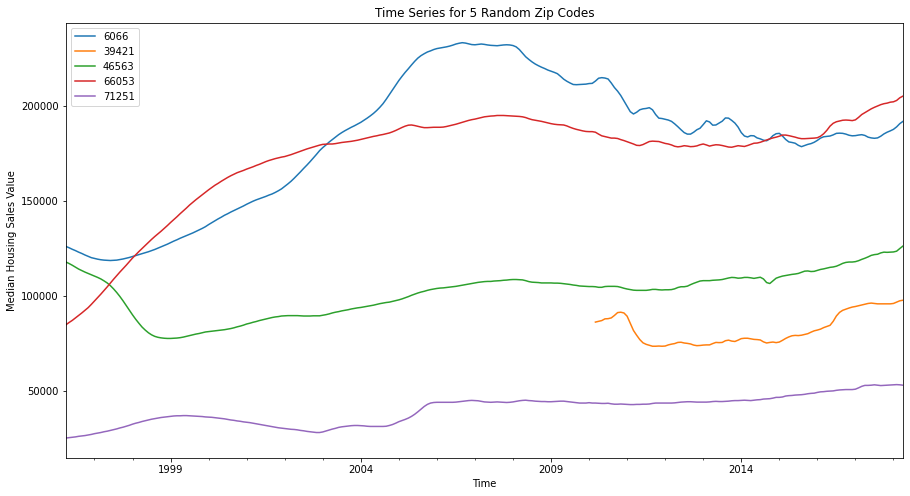

In [5]:
# 5 random integers
sample = np.random.randint(low = 0, high = len(df), size = 5)
random_df = df.copy()
# random_df is simply the 5 random zip codes
random_df = random_df.iloc[sample,:]
# the following is just reformatting the dataframe
random_df.drop(["RegionID", "City", "State", "Metro", "CountyName", 
               "SizeRank"], axis = 1, inplace = True)
random_df.set_index("RegionName", inplace = True)
random_df = random_df.T
random_df.index = pd.to_datetime(random_df.index)
random_df.columns.name = None

random_df.plot(title = "Time Series for 5 Random Zip Codes", figsize = (15,8),
              xlabel = "Time", ylabel = "Median Housing Sales Value");

Every line above follows the same pattern: zip code value starts increasing steadily until it reaches around 2008-2009.  What follows is a dip or plateau for a couple of years until the zip code's value slowly starts increasing at around 2012.

Visualisations like this are important before working with the data as we can notice patterns in the data beforehand.  In this scenario, we noticed that external factors like the 2008 stock market crash *did* affect out time series data. 

## Taking a look at zip codes

Although the question posed by the Bluth Company seems relatively simple and straightforward, there is some ambiguity in determining what the "best zip codes" are.  Should we only take a look at the most recent median housing sales value and sort in descending order?  How do we account for fluctuations over time?  What factors should we consider when comparing a zip code with another?  More importantly, how are we going to reduce our dataframe from 14,723 zip codes to only 5?!

In order to filter through the data and only select a subset of records to analyse, we'll calculate a zip code's annualized return on investment (ROI).  This measure, popular in Finance and Accounting, is commonly used to evaluate the efficiency or profitability of an investment.  As opposed to standard ROI, annualized ROI takes into account time periods.  For example, if we were to use standard ROI, a return of 25% over 5 years is expressed the same as a return of 25% over 5 days.  But obviously, a return of 25% in 5 days is much better than 5 years!

Below is a function to calculate annualized ROI for us that also should handle missing data:

In [6]:
# function to calculate annualized ROI
# takes care of missing values
def AROI(row):
    # time series data starts at index 7
    bools = row[7:].isna()
    for i in range(len(bools)):
        if not bools[i]:
            start = row[7+i]
            end = row[-1]
            num_years = (len(row)-1 - (i+7))/12
            aroi = ((end/start)**(1/num_years))-1
            return round(aroi*100, 2)

Great, now let's calculate the annualized ROI for each zip code present in the data frame:

In [7]:
# apply AROI formula to each row of the dataframe
aroi = df.apply(AROI, axis = 1)

df["AROI"] = aroi
print("Top 10 zip codes by AROI:")
# sort dataframe by AROI in descending fashion
df.sort_values(by = "AROI", ascending = False).head(10)

Top 10 zip codes by AROI:


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,AROI
13409,69649,27980,Hertford,NC,Elizabeth City,Perquimans,13410,NaN,NaN,NaN,...,106600,109900,114000,118100,122200,126600,130600,137300,143900,29.22
842,70817,30032,Candler-Mcafee,GA,Atlanta,Dekalb,843,NaN,NaN,NaN,...,107700,111700,114600,118300,122300,125400,128600,132800,135900,27.66
7302,93292,80216,Denver,CO,Denver,Denver,7303,NaN,NaN,NaN,...,246300,246900,247600,249100,251200,253800,258100,263700,267300,22.58
1998,95769,89030,North Las Vegas,NV,Las Vegas,Clark,1999,NaN,NaN,NaN,...,129200,132000,135400,138400,140100,141600,145100,149100,151300,20.62
4712,97822,94621,Oakland,CA,San Francisco,Alameda,4713,NaN,NaN,NaN,...,367400,371600,376600,381900,387400,390400,393100,399700,405500,20.25
3853,76575,43206,Columbus,OH,Columbus,Franklin,3854,NaN,NaN,NaN,...,68600,68800,69400,71800,75700,78800,81300,84500,88100,18.13
4223,95940,89512,Reno,NV,Reno,Washoe,4224,NaN,NaN,NaN,...,208300,210900,212500,214900,218300,221200,224100,228500,232200,17.83
9302,71010,30288,Conley,GA,Atlanta,Dekalb,9303,NaN,NaN,NaN,...,82100,84400,86400,89300,91900,93400,96300,100300,102600,17.71
2805,98131,95351,Modesto,CA,Modesto,Stanislaus,2806,NaN,NaN,NaN,...,204200,207200,211300,214100,217000,219700,222200,225100,228500,16.73
9218,71997,32435,Defuniak Springs,FL,Crestview-Fort Walton Beach-Destin,Walton,9219,NaN,NaN,NaN,...,102600,103600,103800,102700,102400,103300,104400,105700,106700,16.64


The data frame above shows the top 10 zip codes by annualized ROI in descending order.  Notice how all 10 rows have missing values in the first few months of 1996.  Furthermore, probably the most expensive cities to live in (New York City, Los Angeles, Washington D.C., etc.) aren't even present in the results above!

To get a better sense of the data, let's visualise the results:

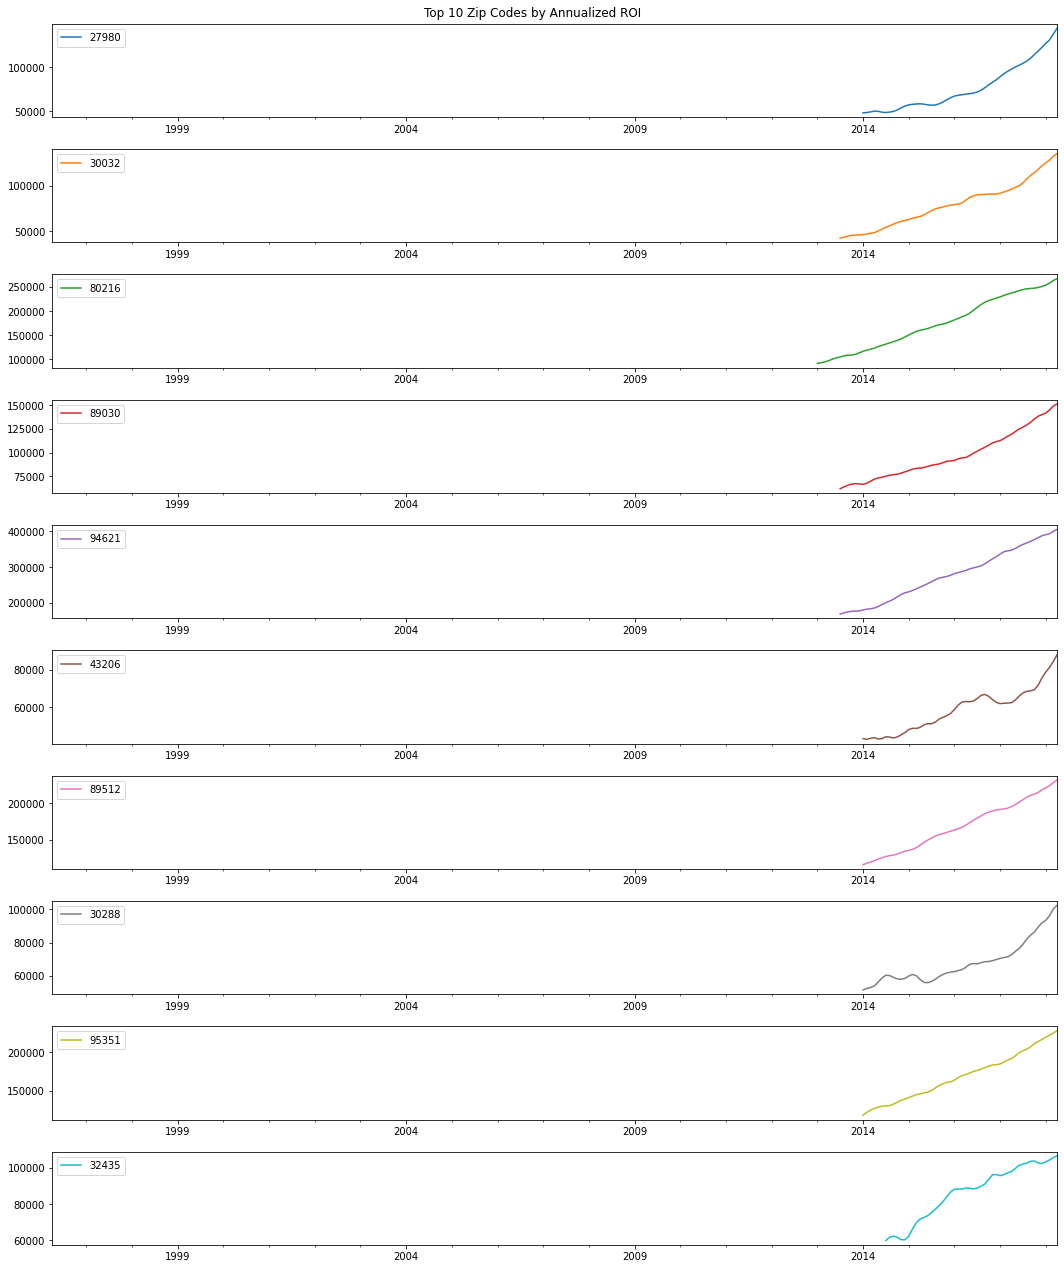

In [8]:
# transforming top 10 data into good format for plotting
df_top10 = df.copy()
df_top10 = df_top10.sort_values(by = "AROI", ascending = False).head(10)
df_top10.drop(["RegionID", "City", "State", "Metro", "CountyName", 
               "SizeRank", "AROI"], axis = 1, inplace = True)
df_top10.set_index("RegionName", inplace = True)
df_top10 = df_top10.T
df_top10.index = pd.to_datetime(df_top10.index)
df_top10.plot(figsize = (15,18), subplots = True, sharex = False,
             title = "Top 10 Zip Codes by Annualized ROI")
plt.tight_layout(pad = 1.5);

As suspected, all of the plots shown above have missing data for the vast majority of the time frame.  All of the values for the zip codes start at around 2014!  Even though these may be the "best" zip codes in terms of annualized ROI, we need more data to confidently construct sound time series models.

### Filtering the Data

The business problem we have at hand asks what are the best zip codes to invest in **today**.  In other words, what are the zip codes that will most likely yield the greatest return?  Even though historical data from 1996 provides context and allows anyone to see how the zip code's value increased over time, a potential investor will most likely be interested in the zip code's _future_ value.  Additionally, forecasting will most likely be affected by more recent data than data gathered 22 years ago.  Furthermore, an event like the stock market crash of 2008 can greatly skew our predictions later on.

Given the nature of our business problem and the historical context, **I'll only be looking at values from 2010 onwards**.  Furthermore, I'll exclude any rows that have missing data in them.  Even though we're excluding 14 years of data, I believe the predictions made by the time series models later on will most likely depend on recent values.  Additionally, this should also reduce the effect of the stock market crash on our data.

In [9]:
# removing data from 1996-2010
df.drop(df.columns[7:172], axis = 1, inplace = True)
# recalculating annualized ROI
df = df.drop("AROI", axis = 1)
aroi = df.apply(AROI, axis = 1)
df["AROI"] = aroi
# removing any rows with NA
df = df[~(df.isna().any(axis = 1))]

print("We now have", df.shape[0], "rows")
print("We now have", df.shape[1], "columns")

We now have 13301 rows
We now have 108 columns


In [10]:
# top 10 zip codes that have at least 10 years of data
df.sort_values(by = "AROI", ascending = False).head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-01,2010-02,2010-03,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,AROI
475,62027,11216,New York,NY,New York,Kings,476,490200.0,490600.0,489000.0,...,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700,15.41
4436,72923,33936,Lehigh Acres,FL,Fort Myers,Lee,4437,46400.0,46300.0,46300.0,...,124000,125900,127500,128600,129600,130500,131200,132000,133200,13.64
1853,97850,94804,Richmond,CA,San Francisco,Contra Costa,1854,169900.0,170400.0,170100.0,...,434100,438900,441700,443900,448000,452400,459200,471800,483100,13.50
1155,62033,11222,New York,NY,New York,Kings,1156,608500.0,610000.0,599200.0,...,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,13.43
5738,97691,94301,Palo Alto,CA,San Jose,Santa Clara,5739,1710700.0,1718100.0,1715300.0,...,4247600,4319300,4401100,4481700,4544700,4595100,4668700,4762600,4818400,13.37
3794,72388,33056,Miami Gardens,FL,Miami-Fort Lauderdale,Miami-Dade,3795,82800.0,82000.0,80600.0,...,214300,218100,221200,222700,224400,227000,228500,229300,230300,13.20
2580,97530,94043,Mountain View,CA,San Jose,Santa Clara,2581,750700.0,751800.0,751200.0,...,1745300,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,13.11
5328,97551,94089,Sunnyvale,CA,San Jose,Santa Clara,5329,438200.0,439600.0,433900.0,...,1005100,1030600,1060800,1090100,1113200,1130100,1149300,1180300,1206600,13.06
474,94724,85008,Phoenix,AZ,Phoenix,Maricopa,475,81600.0,80500.0,79700.0,...,204200,206700,209200,210200,210300,211300,213900,218800,223000,12.96
4298,98433,95824,Sacramento,CA,Sacramento,Sacramento,4299,82300.0,81900.0,83000.0,...,211700,213300,214500,215900,218400,221400,223500,224700,224700,12.95


Having removed data from 1996-2009 and any rows with missing data, our top 10 zip codes changed quite a bit.  5 out of the 10 zip codes are located in California, 2 in New York and Florida, and only one in Arizona.

Once again, the best way to inspect time series data is through visualisations.  Let's check it out:

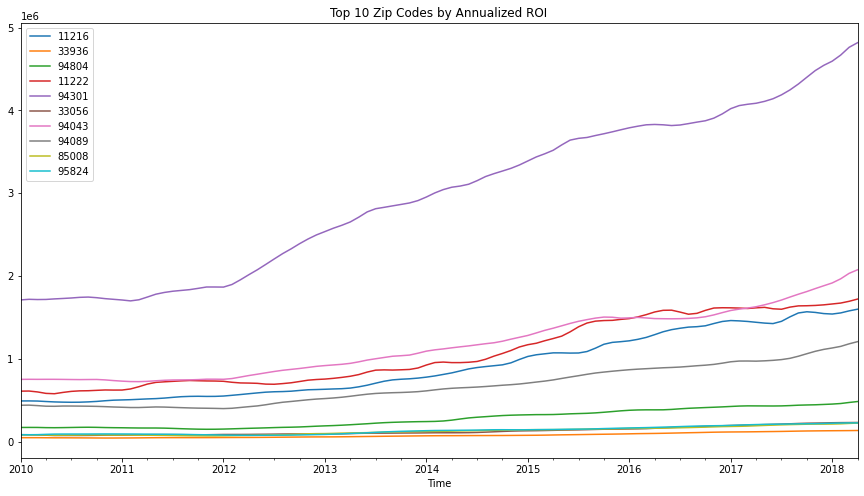

In [11]:
# reformatting dataframe and plotting
df_top10 = df.copy()
df_top10 = df_top10.sort_values(by = "AROI", ascending = False).head(10)
df_top10.drop(["RegionID", "City", "State", "Metro", "CountyName", 
               "SizeRank", "AROI"], axis = 1, inplace = True)
df_top10.set_index("RegionName", inplace = True)
df_top10 = df_top10.T
df_top10.index = pd.to_datetime(df_top10.index)
df_top10.columns.name = None
df_top10.plot(figsize = (15,8), title = "Top 10 Zip Codes by Annualized ROI",
             xlabel = "Time");

Despite these zip codes having fairly similar annualized ROIs, 94301 stands out from the rest.  This zip code, located in Palo Alto, CA, has substantially higher values than the rest.

## Selecting the 5 Zip Codes

We can now select the 5 zip codes we'll train our models with.  Given that we chose annualized ROI as our metric of interest, we'll select the zip codes by sorting the data in descending order and choosing the top 5:

In [12]:
# creating our top 5 dataframe
df_top5 = df_top10.iloc[:,:5]

df_top5.head()

,11216,33936,94804,11222,94301
2010-01-01,490200.0,46400.0,169900.0,608500.0,1710700.0
2010-02-01,490600.0,46300.0,170400.0,610000.0,1718100.0
2010-03-01,489000.0,46300.0,170100.0,599200.0,1715300.0
2010-04-01,483400.0,45500.0,167800.0,581600.0,1716500.0
2010-05-01,478500.0,44800.0,167000.0,577400.0,1723000.0


The selected zip codes for our time series models are therefore 11216, 33936, 94804, 11222, and 94301.

The final time series visualisation is shown below:

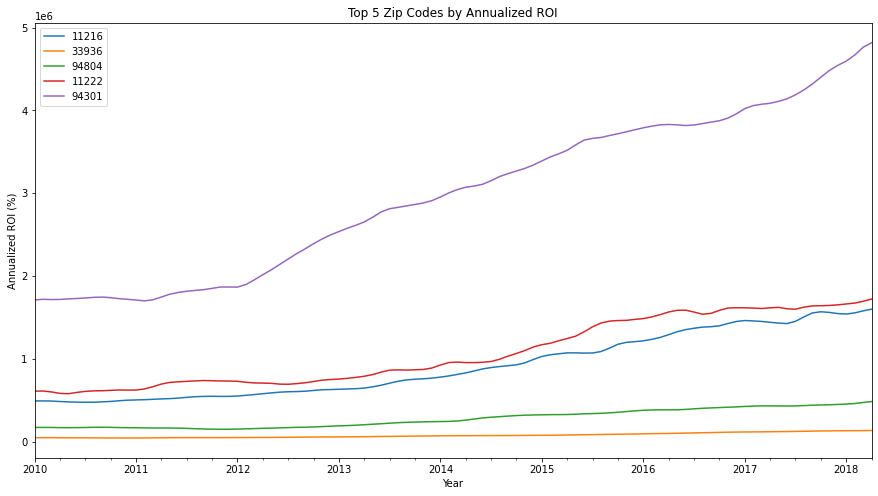

In [13]:
# plotting all time series in the same plot
df_top5.plot(figsize = (15,8), title = "Top 5 Zip Codes by Annualized ROI",
            xlabel = "Year", ylabel = "Annualized ROI (%)");
#plt.savefig("./images/top5.png", dpi = 150, bbox_inches = "tight")

Given the nature of our data, I thought it might be a good idea to know exactly where each zip code is located.  Below is an interactive map which shows which zip codes we'll be working with later on:

In [14]:
import folium

usa = folium.Map(location = [40.693943, -73.985880])

folium.Choropleth(geo_data = "data/zips.geojson",
               data = df.sort_values("AROI", ascending = False).head(),
               columns = ["RegionName", "AROI"],
               key_on = "feature.properties.postalCode",
               fill_color = "YlOrBr", fill_opacity = 0.7, line_opacity = 0.3,
               legend_name = "Annualized ROI").add_to(usa)

lat = [40.6812677, 26.6085858, 37.9253042, 40.732811, 37.4435912]
long = [-73.9641288, -81.6024707, -122.3482457, -73.9528337, -122.1541117]

for i in range(5):
    county = df.sort_values("AROI", ascending = False).head().iloc[i]["CountyName"]
    state = df.sort_values("AROI", ascending = False).head().iloc[i]["State"]
    popup = county + " County, {}".format(state)
    
    zip_code = df.sort_values("AROI", ascending = False).head().iloc[i]["RegionName"]
    
    folium.Marker([lat[i], long[i]], popup = popup, 
                  tooltip = zip_code).add_to(usa)

usa

Having selected our 5 zip codes using annualized ROI, we are now ready to start the modelling stage where we'll use a popular time series method for forecasting.

In [15]:
# saving dataframes for use in the next notebook
df.to_csv("data/df.csv")
df_top5.to_csv("data/df_top5.csv")

Please click [here](ARIMA.ipynb) to continue on with this project!

----